In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 1024
LR = 1e-3
EPOCHS = 20
DATASET = 'MNIST'

print(f"Running on {device}")

Running on cuda


In [46]:
# ==========================================
# 2. Model Architecture (FIXED: NO DEADLOCK)
# ==========================================

class Squeeze(nn.Module):
    def forward(self, x, invert=False):
        B, C, H, W = x.shape
        if not invert:
            x = x.view(B, C, H//2, 2, W//2, 2)
            x = x.permute(0, 1, 3, 5, 2, 4).contiguous()
            x = x.view(B, C*4, H//2, W//2)
            return x
        else:
            x = x.view(B, C//4, 2, 2, H, W)
            x = x.permute(0, 1, 4, 2, 5, 3).contiguous()
            x = x.view(B, C//4, H*2, W*2)
            return x

class Split(nn.Module):
    def forward(self, x):
        x, z = x.chunk(2, dim=1)
        return x, z

    def inverse(self, x, z):
        return torch.cat([x, z], dim=1)

class ResNetSimple(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 1),
            nn.ReLU(),
            nn.Conv2d(128, out_channels, 3, padding=1)
        )

    def forward(self, x):
        return self.net(x)

class CouplingLayer(nn.Module):
    def __init__(self, channels, mask_type='checkerboard', reverse=False):
        super().__init__()
        self.mask_type = mask_type
        self.reverse = reverse
        self.net = ResNetSimple(channels, channels * 2)

    def get_mask(self, x):
        B, C, H, W = x.shape
        if self.mask_type == 'checkerboard':
            mask = torch.from_numpy(
                ((np.indices((H, W)).sum(axis=0) % 2) == 0)
            ).float().to(x.device)
            if self.reverse:
                mask = 1 - mask
            return mask.view(1, 1, H, W)
        else:
            mask = torch.zeros_like(x)
            mask[:, :C//2] = 1
            if self.reverse:
                mask = 1 - mask
            return mask

    def forward(self, x, invert=False):
        mask = self.get_mask(x)
        x_masked = x * mask

        s, t = self.net(x_masked).chunk(2, dim=1)
        s = 0.8 * torch.tanh(s)   # STABLE scaling

        if not invert:
            y = x * torch.exp(s * (1 - mask)) + t * (1 - mask)
            log_det = (s * (1 - mask)).sum(dim=[1,2,3])
            return y, log_det
        else:
            y = (x - t * (1 - mask)) * torch.exp(-s * (1 - mask))
            return y

class RealNVP(nn.Module):
    def __init__(self):
        super().__init__()

        # Scale 1 (28×28)
        self.c1 = CouplingLayer(1, 'checkerboard')
        self.c2 = CouplingLayer(1, 'checkerboard', reverse=True)

        # Downscale
        self.squeeze = Squeeze()
        self.split = Split()

        # Scale 2 (14×14)
        self.c3 = CouplingLayer(2, 'channel')
        self.c4 = CouplingLayer(2, 'channel', reverse=True)
        self.c5 = CouplingLayer(2, 'channel')

    def forward(self, x):
        log_det = 0

        # Scale 1
        x, ld = self.c1(x); log_det += ld
        x, ld = self.c2(x); log_det += ld

        # Downscale + split
        x = self.squeeze(x)
        x, z1 = self.split(x)

        # Scale 2
        x, ld = self.c3(x); log_det += ld
        x, ld = self.c4(x); log_det += ld
        x, ld = self.c5(x); log_det += ld

        # x is z2
        return (x, z1), log_det

    def inverse(self, z):
        z2, z1 = z

        # Reverse scale 2
        x = self.c5(z2, invert=True)
        x = self.c4(x, invert=True)
        x = self.c3(x, invert=True)

        # Merge + upscale
        x = self.split.inverse(x, z1)
        x = self.squeeze(x, invert=True)

        # Reverse scale 1
        x = self.c2(x, invert=True)
        x = self.c1(x, invert=True)

        return x

In [47]:
# ==========================================
# 3. Helpers & Loss
# ==========================================

def get_loss(model, x):
    (z2, z1), log_det = model(x)

    z = torch.cat([z2, z1], dim=1)
    prior = -0.5 * (z**2 + np.log(2*np.pi))
    prior = prior.sum(dim=[1,2,3])

    return -(prior + log_det).mean()

# ==========================================
# 4. Data Loading
# ==========================================

class Dequantize(object):
    def __call__(self, x):
        return x + torch.rand_like(x) / 256

transform = transforms.Compose([
    transforms.ToTensor(),
    Dequantize()
])

train_set = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)


In [48]:
model = RealNVP().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)

train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0

    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        loss = get_loss(model, x)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            val_loss += get_loss(model, x).item()

    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}: Train {train_loss:.2f} | Val {val_loss:.2f}")


Epoch 1: Train -71.14 | Val -234.24
Epoch 2: Train -249.00 | Val -265.57
Epoch 3: Train -279.49 | Val -291.28
Epoch 4: Train -298.34 | Val -304.70
Epoch 5: Train -167.21 | Val -263.19
Epoch 6: Train -287.81 | Val -299.14
Epoch 7: Train -302.59 | Val -305.55
Epoch 8: Train -307.28 | Val -309.13
Epoch 9: Train -310.35 | Val -311.85
Epoch 10: Train -312.83 | Val -314.17
Epoch 11: Train -315.05 | Val -316.34
Epoch 12: Train -317.09 | Val -318.29
Epoch 13: Train -318.96 | Val -320.12
Epoch 14: Train -320.73 | Val -321.86
Epoch 15: Train -322.44 | Val -323.51
Epoch 16: Train -324.06 | Val -325.12
Epoch 17: Train -325.60 | Val -326.62
Epoch 18: Train -327.03 | Val -327.93
Epoch 19: Train -328.35 | Val -329.23
Epoch 20: Train -329.60 | Val -330.49


Ateempt 1 (20 epochs, batch 64, MNIST)

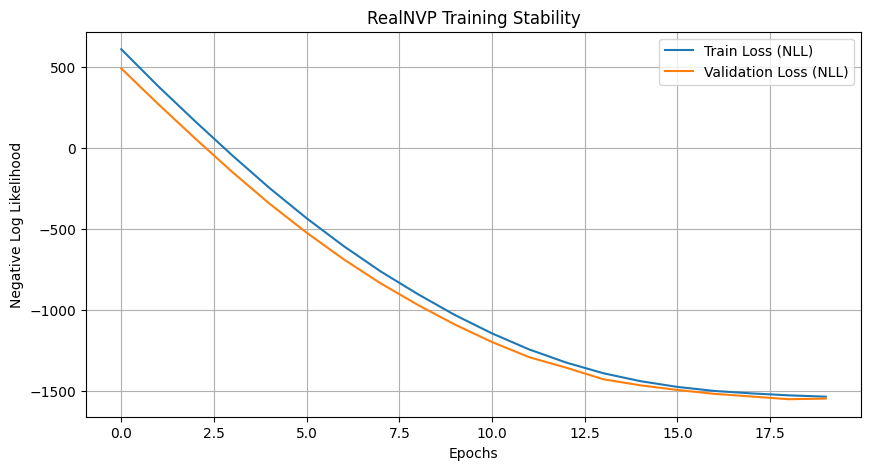

Generating samples...


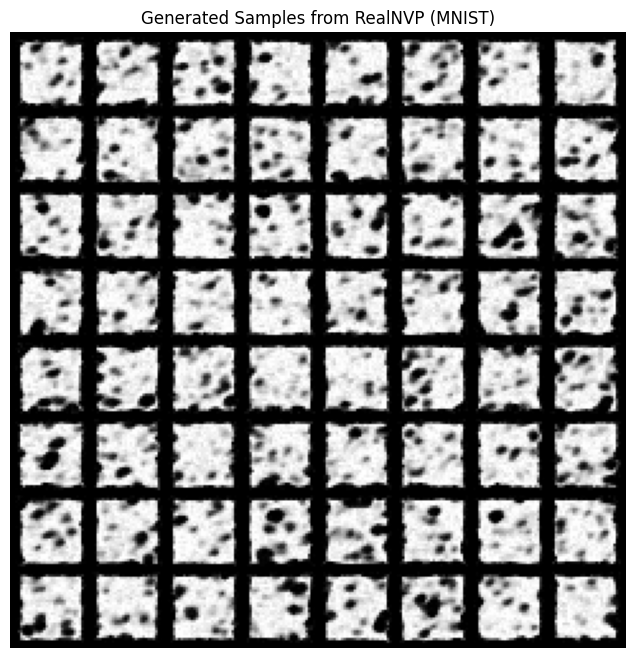

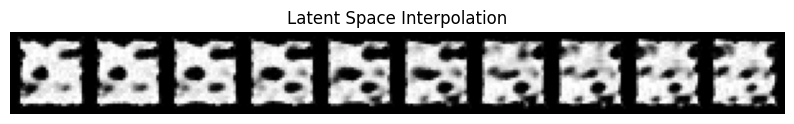

In [5]:
# ==========================================
# 6. Visualization & Evaluation
# ==========================================

# 1. Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss (NLL)')
plt.plot(test_losses, label='Validation Loss (NLL)')
plt.xlabel('Epochs')
plt.ylabel('Negative Log Likelihood')
plt.title('RealNVP Training Stability')
plt.legend()
plt.grid(True)
plt.show()

# 2. Generate Samples
print("Generating samples...")
model.eval()
generated_imgs = sample_images(model, n_samples=64)

# Plot Grid
grid_img = torchvision.utils.make_grid(generated_imgs, nrow=8, padding=2)
plt.figure(figsize=(8, 8))
plt.imshow(grid_img.permute(1, 2, 0).numpy(), cmap='gray')
plt.axis('off')
plt.title(f'Generated Samples from RealNVP ({DATASET})')
plt.show()

# 3. Latent Space Interpolation (Optional but cool for report)
def interpolate(model, n_steps=10):
    z1 = torch.randn(1, 1, 28, 28).to(device)
    z2 = torch.randn(1, 1, 28, 28).to(device)

    alphas = torch.linspace(0, 1, n_steps).to(device)
    interpolated_imgs = []

    with torch.no_grad():
        for alpha in alphas:
            z_interp = (1 - alpha) * z1 + alpha * z2
            x_interp = model.inverse(z_interp)
            interpolated_imgs.append(x_interp.cpu())

    return torch.cat(interpolated_imgs)

interp_imgs = interpolate(model)
grid_interp = torchvision.utils.make_grid(interp_imgs, nrow=10, padding=2)
plt.figure(figsize=(10, 2))
plt.imshow(grid_interp.permute(1, 2, 0).numpy(), cmap='gray')
plt.axis('off')
plt.title('Latent Space Interpolation')
plt.show()

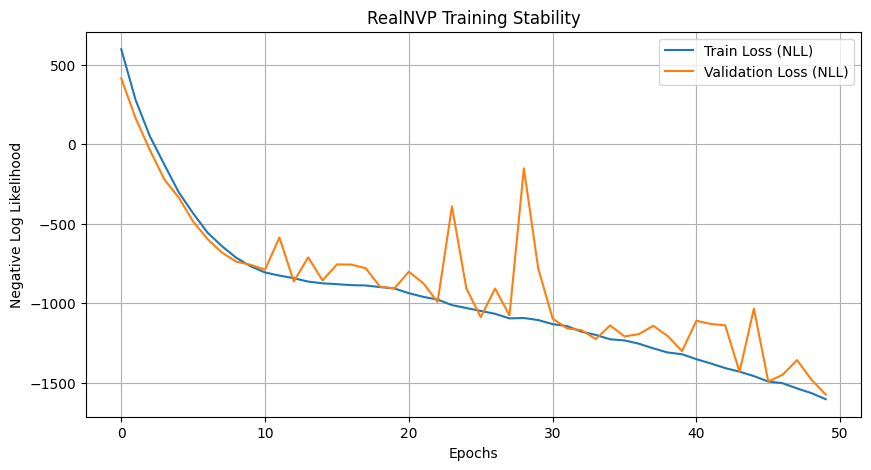

Generating samples...


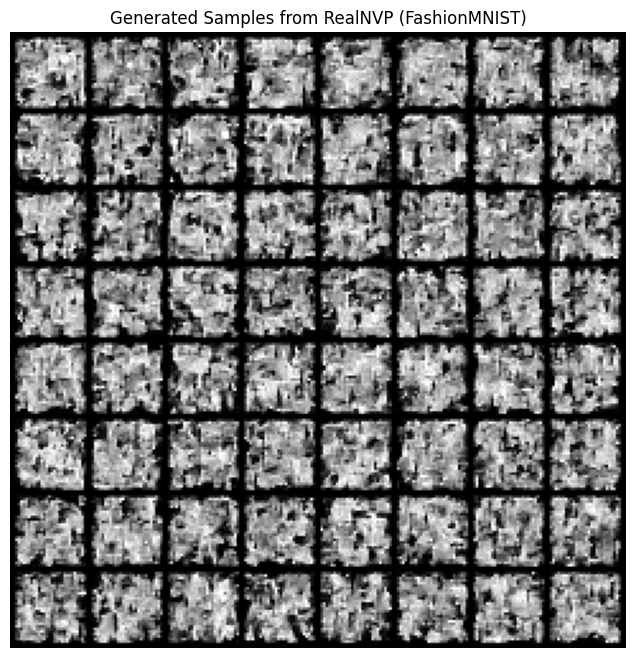

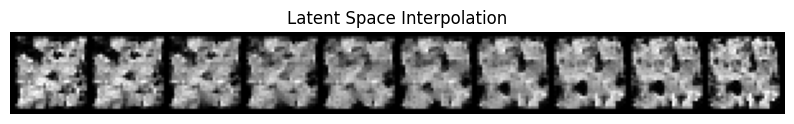

In [10]:
# ==========================================
# 6. Visualization & Evaluation
# ==========================================

# 1. Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss (NLL)')
plt.plot(test_losses, label='Validation Loss (NLL)')
plt.xlabel('Epochs')
plt.ylabel('Negative Log Likelihood')
plt.title('RealNVP Training Stability')
plt.legend()
plt.grid(True)
plt.show()

# 2. Generate Samples
print("Generating samples...")
model.eval()
generated_imgs = sample_images(model, n_samples=64)

# Plot Grid
grid_img = torchvision.utils.make_grid(generated_imgs, nrow=8, padding=2)
plt.figure(figsize=(8, 8))
plt.imshow(grid_img.permute(1, 2, 0).numpy(), cmap='gray')
plt.axis('off')
plt.title(f'Generated Samples from RealNVP ({DATASET})')
plt.show()

# 3. Latent Space Interpolation (Optional but cool for report)
def interpolate(model, n_steps=10):
    z1 = torch.randn(1, 1, 28, 28).to(device)
    z2 = torch.randn(1, 1, 28, 28).to(device)

    alphas = torch.linspace(0, 1, n_steps).to(device)
    interpolated_imgs = []

    with torch.no_grad():
        for alpha in alphas:
            z_interp = (1 - alpha) * z1 + alpha * z2
            x_interp = model.inverse(z_interp)
            interpolated_imgs.append(x_interp.cpu())

    return torch.cat(interpolated_imgs)

interp_imgs = interpolate(model)
grid_interp = torchvision.utils.make_grid(interp_imgs, nrow=10, padding=2)
plt.figure(figsize=(10, 2))
plt.imshow(grid_interp.permute(1, 2, 0).numpy(), cmap='gray')
plt.axis('off')
plt.title('Latent Space Interpolation')
plt.show()

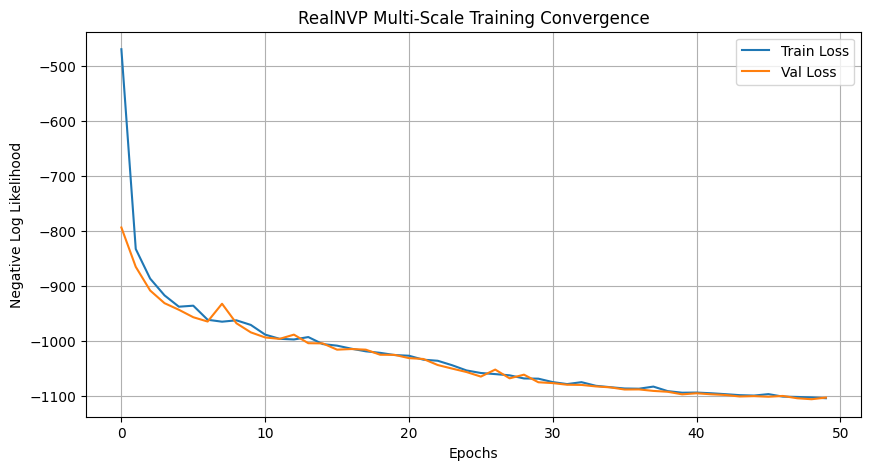

Generating samples from Multi-Scale model...


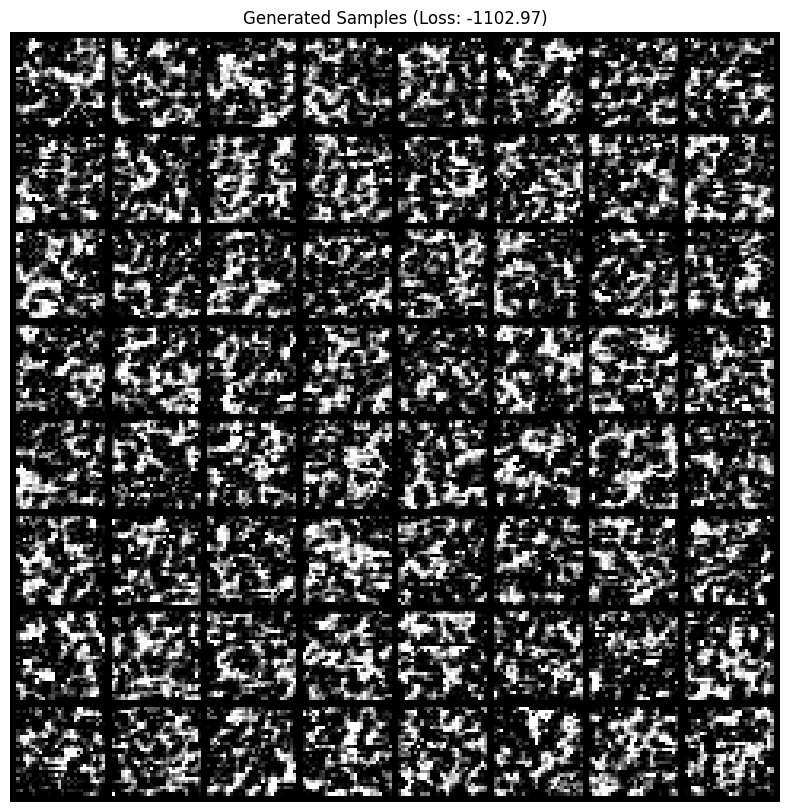

In [29]:
# ==========================================
# 6. Visualization (UPDATED for Multi-Scale)
# ==========================================

def sample_images(model, n_samples=64):
    model.eval()
    with torch.no_grad():
        # CRITICAL: The shape is now 4 channels, 14x14 spatial resolution
        z = torch.randn(n_samples, 4, 14, 14).to(device)

        # Invert the flow: z (noise) -> x (image)
        x_gen = model.inverse(z)

        # Clamp to valid image range [0, 1]
        x_gen = torch.clamp(x_gen, 0, 1)

    return x_gen.cpu()

# 1. Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Val Loss')
plt.title('RealNVP Multi-Scale Training Convergence')
plt.xlabel('Epochs')
plt.ylabel('Negative Log Likelihood')
plt.legend()
plt.grid(True)
plt.show()

# 2. Show Samples
print("Generating samples from Multi-Scale model...")
generated_imgs = sample_images(model)

grid_img = torchvision.utils.make_grid(generated_imgs, nrow=8, padding=2)
plt.figure(figsize=(10, 10))
plt.imshow(grid_img.permute(1, 2, 0).numpy(), cmap='gray')
plt.axis('off')
plt.title(f'Generated Samples (Loss: {test_losses[-1]:.2f})')
plt.show()

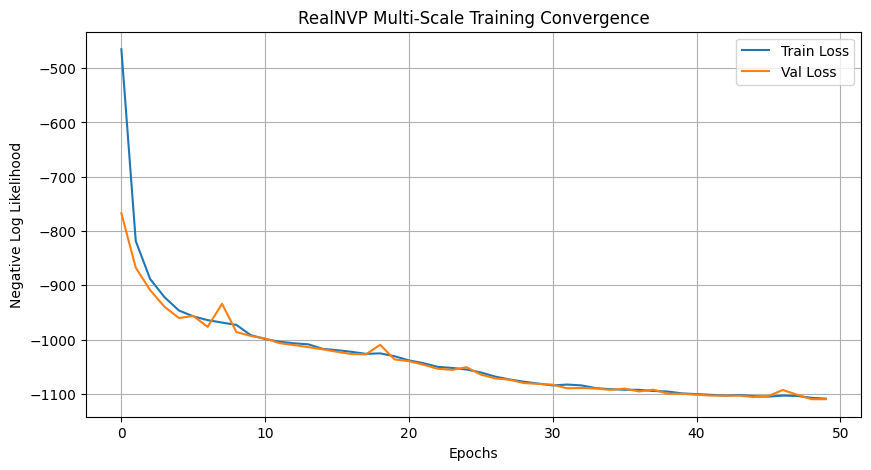

Generating samples from Multi-Scale model...


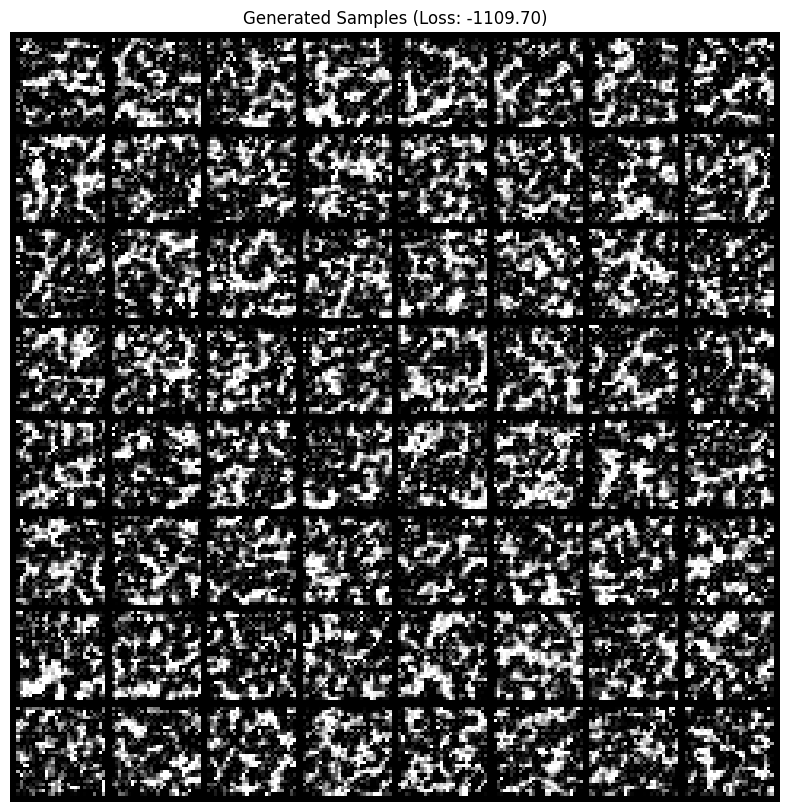

In [34]:
# ==========================================
# 6. Visualization (UPDATED for Multi-Scale)
# ==========================================

def sample_images(model, n=64):
    model.eval()
    with torch.no_grad():
        # Coarse latent (structure)
        z1 = torch.randn(n, 2, 14, 14).to(device) * 0.4

        # Fine latent (noise)
        z2 = torch.randn(n, 2, 14, 14).to(device) * 0.15

        x = model.inverse((z2, z1))
        x = torch.clamp(x, 0, 1)
    return x.cpu()

# 1. Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Val Loss')
plt.title('RealNVP Multi-Scale Training Convergence')
plt.xlabel('Epochs')
plt.ylabel('Negative Log Likelihood')
plt.legend()
plt.grid(True)
plt.show()

# 2. Show Samples
print("Generating samples from Multi-Scale model...")
generated_imgs = sample_images(model)

grid_img = torchvision.utils.make_grid(generated_imgs, nrow=8, padding=2)
plt.figure(figsize=(10, 10))
plt.imshow(grid_img.permute(1, 2, 0).numpy(), cmap='gray')
plt.axis('off')
plt.title(f'Generated Samples (Loss: {test_losses[-1]:.2f})')
plt.show()

In [49]:
def sample_images(model, n=64):
    model.eval()
    with torch.no_grad():
        # Coarse latent (structure)
        z1 = torch.randn(n, 2, 14, 14).to(device) * 0.4

        # Fine latent (noise)
        z2 = torch.randn(n, 2, 14, 14).to(device) * 0.15

        x = model.inverse((z2, z1))
        x = torch.clamp(x, 0, 1)
    return x.cpu()

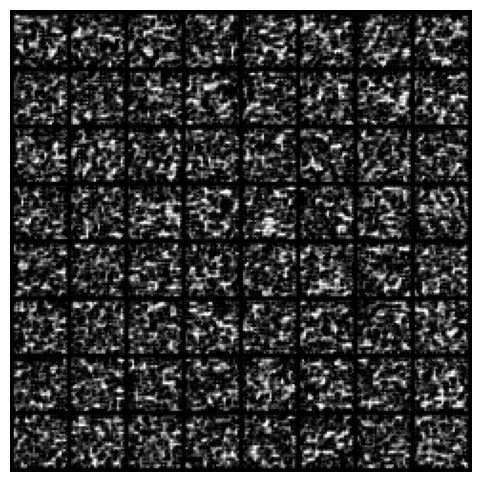

In [50]:
samples = sample_images(model)
grid = torchvision.utils.make_grid(samples, nrow=8)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1,2,0), cmap='gray')
plt.axis('off')
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
BATCH_SIZE = 64  # Smaller batch size often helps flows converge smoother
LR = 1e-4
EPOCHS = 20
DATASET = 'MNIST'

print(f"Running on {device}")

# ==========================================
# 2. Model Architecture (IMPROVED)
# ==========================================

class Squeeze(nn.Module):
    def forward(self, x, invert=False):
        B, C, H, W = x.shape
        if not invert:
            # Squeeze: (B, C, H, W) -> (B, 4*C, H/2, W/2)
            x = x.view(B, C, H//2, 2, W//2, 2)
            x = x.permute(0, 1, 3, 5, 2, 4).contiguous()
            x = x.view(B, C*4, H//2, W//2)
            return x
        else:
            # Unsqueeze: (B, 4*C, H, W) -> (B, C, H*2, W*2)
            # We must explicitly infer output channels to avoid shape errors
            x = x.view(B, C//4, 2, 2, H, W)
            x = x.permute(0, 1, 4, 2, 5, 3).contiguous()
            x = x.view(B, C//4, H*2, W*2)
            return x

class Split(nn.Module):
    def forward(self, x):
        # Splits the channel dimension in half
        x, z = x.chunk(2, dim=1)
        return x, z

    def inverse(self, x, z):
        # Concatenates back
        return torch.cat([x, z], dim=1)

class ResNetSimple(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # WIDER = Better Quality
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, out_channels, 3, padding=1)
        )
        # Zero Init (Critical)
        self.net[-1].weight.data.zero_()
        self.net[-1].bias.data.zero_()

    def forward(self, x):
        return self.net(x)


class CouplingLayer(nn.Module):
    def __init__(self, channels, mask_type='checkerboard', reverse=False):
        super().__init__()
        self.mask_type = mask_type
        self.reverse = reverse

        # Neural net to predict scale (s) and translation (t)
        self.net = ResNetSimple(channels, channels * 2)

        # Learnable scale parameter to help convergence
        self.scale = nn.Parameter(torch.ones(1))

    def get_mask(self, x):
        B, C, H, W = x.shape
        if self.mask_type == 'checkerboard':
            mask = ((np.indices((H, W)).sum(axis=0) % 2) == 0)
            mask = torch.from_numpy(mask).float().to(x.device).view(1, 1, H, W)
        else:
            mask = torch.zeros((1, C, 1, 1), device=x.device)
            mask[:, :C//2, :, :] = 1

        if self.reverse:
            mask = 1 - mask
        return mask

    def forward(self, x, invert=False):
        mask = self.get_mask(x)
        x_masked = x * mask

        s_t = self.net(x_masked)
        s, t = s_t.chunk(2, dim=1)

        # STABILIZATION FIX: Tanh * scale
        # This prevents 's' from ever being too large, preventing exp(s) explosion
        s = torch.tanh(s) * self.scale

        if not invert:
            # y = x * exp(s) + t
            y = x * torch.exp(s * (1 - mask)) + t * (1 - mask)
            log_det = (s * (1 - mask)).sum(dim=[1, 2, 3])
            return y, log_det
        else:
            # x = (y - t) * exp(-s)
            y = (x - t * (1 - mask)) * torch.exp(-s * (1 - mask))
            return y

class RealNVP(nn.Module):
    def __init__(self):
        super().__init__()

        # Deeper flow (3 layers per scale) is a sweet spot for stability vs quality
        self.scale1 = nn.ModuleList([
            CouplingLayer(1, 'checkerboard', reverse=False),
            CouplingLayer(1, 'checkerboard', reverse=True),
            CouplingLayer(1, 'checkerboard', reverse=False)
        ])

        self.squeeze = Squeeze() # Uses the Squeeze class you already have
        self.split = Split()     # Uses the Split class you already have

        self.scale2 = nn.ModuleList([
            CouplingLayer(2, 'channel', reverse=False),
            CouplingLayer(2, 'channel', reverse=True),
            CouplingLayer(2, 'channel', reverse=False)
        ])

    def forward(self, x):
        log_det = 0

        for layer in self.scale1:
            x, ld = layer(x)
            log_det += ld

        x = self.squeeze(x)
        x, z1 = self.split(x)

        for layer in self.scale2:
            x, ld = layer(x)
            log_det += ld

        return (x, z1), log_det

    def inverse(self, z):
        z2, z1 = z
        x = z2

        for layer in reversed(self.scale2):
            x = layer(x, invert=True)

        x = self.split.inverse(x, z1)
        x = self.squeeze(x, invert=True)

        for layer in reversed(self.scale1):
            x = layer(x, invert=True)

        return x

# ==========================================
# 3. Helpers & Loss
# ==========================================

def get_loss(model, x):
    (z2, z1), log_det = model(x)

    # Calculate Gaussian NLL
    z = torch.cat([z2, z1], dim=1)

    # Standard Normal Prior NLL: 0.5 * (z^2 + log(2pi))
    prior_nll = 0.5 * (z**2 + np.log(2 * np.pi))
    prior_nll = prior_nll.sum(dim=[1,2,3])

    # NLL = Prior_NLL - Log_Det
    loss = prior_nll - log_det
    return loss.mean()

# ==========================================
# 4. Data & Training
# ==========================================

class Dequantize(object):
    def __call__(self, x):
        # Convert discrete [0, 255] to continuous [0, 1]
        return x + torch.rand_like(x) / 256.0

transform = transforms.Compose([
    transforms.ToTensor(), # Output is [0, 1]
    Dequantize()
])

train_set = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform)

# Increased batch size slightly for stable BN statistics
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, drop_last=True)

model = RealNVP().to(device)
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
optimizer = optim.Adam(model.parameters(), lr=LR)

print("Starting training...")

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0

    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        loss = get_loss(model, x)
        loss.backward()

        # Gradient clipping prevents explosion in early epochs
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}")

# ==========================================
# 5. Visualization
# ==========================================

def sample_images(model, n=64):
    model.eval()
    with torch.no_grad():
        # Multiply by 0.6 to reduce variance (Temperature Sampling)
        z1 = torch.randn(n, 2, 14, 14).to(device) * 0.6
        z2 = torch.randn(n, 2, 14, 14).to(device) * 0.6

        # Invert
        x = model.inverse((z2, z1))
        x = torch.clamp(x, 0, 1)
    return x.cpu()

samples = sample_images(model)
grid = torchvision.utils.make_grid(samples, nrow=8)
plt.figure(figsize=(8,8))
plt.imshow(grid.permute(1,2,0), cmap='gray')
plt.axis('off')
plt.title("Generated Samples")
plt.show()

Running on cuda
Starting training...
Epoch 1: Train Loss -893.9292
Epoch 2: Train Loss -1066.1578
Epoch 3: Train Loss -1184.5814
Epoch 4: Train Loss -1289.5768
Epoch 5: Train Loss -1385.2436
Epoch 6: Train Loss -1470.4845
Epoch 7: Train Loss -1548.2375
Epoch 8: Train Loss -1623.1479
Epoch 9: Train Loss -1691.5648
Epoch 10: Train Loss -1755.2543
Epoch 11: Train Loss -1806.9843
Epoch 12: Train Loss -1862.7742
Epoch 13: Train Loss -1914.8003
Epoch 14: Train Loss -1971.7264
